In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import timm
import random

# GPU 이용가능한 리눅스 환경인 경우 tsnecuda, 그렇지 않은 경우 sklearn 사용해야함
# from tsnecuda import TSNE 
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from torchvision.models import wide_resnet50_2
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
df = pd.read_csv('./train_df.csv')
df.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [3]:
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      4277 non-null   int64 
 1   file_name  4277 non-null   object
 2   class      4277 non-null   object
 3   state      4277 non-null   object
 4   label      4277 non-null   object
dtypes: int64(1), object(4)
memory usage: 167.2+ KB


In [4]:
print(len(df['class'].unique()))
df['class'].unique()

15


array(['transistor', 'capsule', 'wood', 'bottle', 'screw', 'cable',
       'carpet', 'hazelnut', 'pill', 'metal_nut', 'zipper', 'leather',
       'toothbrush', 'tile', 'grid'], dtype=object)

In [5]:
print(len(df['state'].unique()))
df['state'].unique()[:10]

49


array(['good', 'bent_wire', 'hole', 'pill_type', 'scratch', 'thread_side',
       'fabric_border', 'crack', 'manipulated_front', 'contamination'],
      dtype=object)

In [6]:
# 'state-class' => 'label' 형태
print(len(df['label'].unique()))
df['label'].unique()[:10]

88


array(['transistor-good', 'capsule-good', 'wood-good', 'bottle-good',
       'screw-good', 'cable-bent_wire', 'carpet-hole', 'hazelnut-good',
       'pill-pill_type', 'cable-good'], dtype=object)

In [7]:
uniqeu_states_dict = {val:idx for idx,val in enumerate(df['state'].unique())}
uniqeu_classes_dict = {val:idx for idx,val in enumerate(df['class'].unique())}
uniqeu_labels_dict = {val:idx for idx,val in enumerate(df['label'].unique())}

In [8]:
train_dirs = sorted(glob('./train/*.png'))

In [9]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512, 512))
    return img

In [10]:
train_imgs,states,classes,labels = [],[],[],[]
for i in range(len(df)):
    train_imgs.append(img_load(train_dirs[i]))
    states.append(uniqeu_states_dict[df['state'][i]])
    classes.append(uniqeu_classes_dict[df['class'][i]])
    labels.append(uniqeu_labels_dict[df['label'][i]])

In [11]:
flatten_train_imgs=[img.flatten() for img in train_imgs]
flatten_train_imgs[:5]

[array([144, 101,  93, ..., 153, 106,  92], dtype=uint8),
 array([235, 225, 225, ..., 216, 212, 209], dtype=uint8),
 array([149, 101,  93, ..., 152, 105,  93], dtype=uint8),
 array([153, 104,  78, ..., 121,  82,  63], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)]

In [12]:
flatten_train_arr = np.array(flatten_train_imgs)
flatten_train_arr[:5]

array([[144, 101,  93, ..., 153, 106,  92],
       [235, 225, 225, ..., 216, 212, 209],
       [149, 101,  93, ..., 152, 105,  93],
       [153, 104,  78, ..., 121,  82,  63],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [13]:
print(flatten_train_arr.shape)

(4277, 786432)


In [14]:
tsne_model = TSNE()
train_tsne = tsne_model.fit_transform(flatten_train_arr)

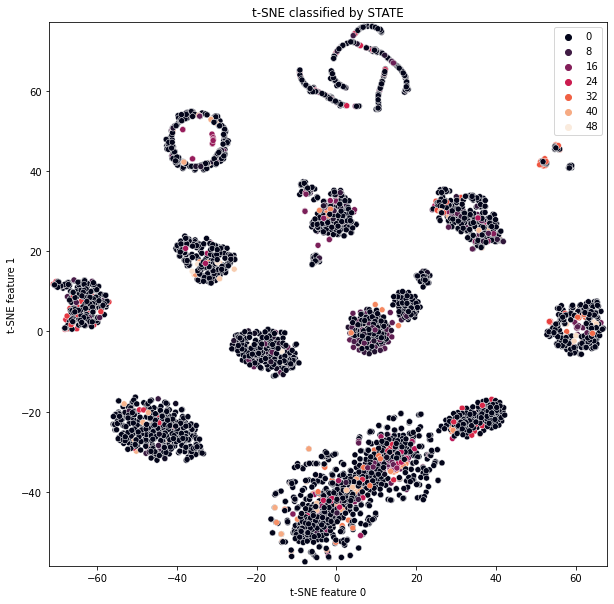

In [15]:
hue = states
plt.figure(figsize=(10,10))
plt.xlim(train_tsne[:,0].min()-1,train_tsne[:,0].max()+1)
plt.ylim(train_tsne[:,1].min()-1,train_tsne[:,1].max()+1)
sns.scatterplot(train_tsne[:,0], train_tsne[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE classified by STATE')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()

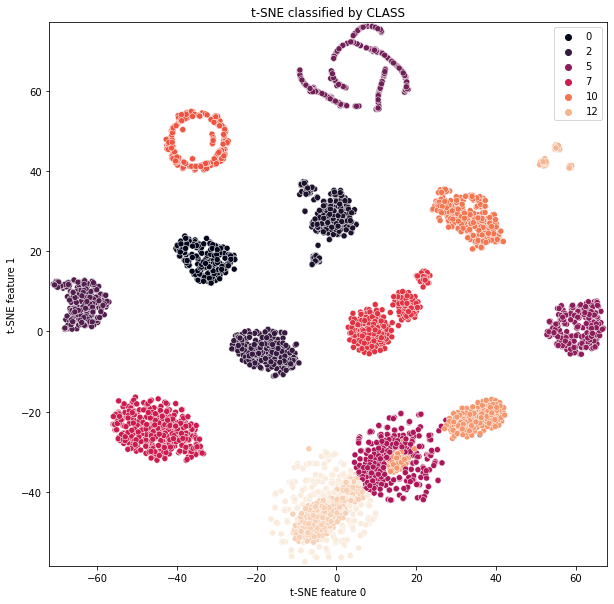

In [16]:
hue = classes
plt.figure(figsize=(10,10))
plt.xlim(train_tsne[:,0].min()-1,train_tsne[:,0].max()+1)
plt.ylim(train_tsne[:,1].min()-1,train_tsne[:,1].max()+1)
sns.scatterplot(train_tsne[:,0], train_tsne[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE classified by CLASS')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()

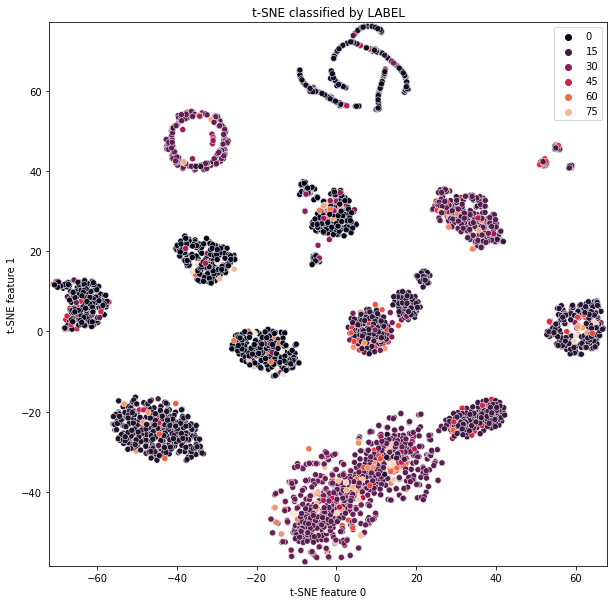

In [17]:
hue = labels
plt.figure(figsize=(10,10))
plt.xlim(train_tsne[:,0].min()-1,train_tsne[:,0].max()+1)
plt.ylim(train_tsne[:,1].min()-1,train_tsne[:,1].max()+1)
sns.scatterplot(train_tsne[:,0], train_tsne[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE classified by LABEL')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()

In [21]:
resnet_model = wide_resnet50_2(pretrained=True)
resnet_model.eval()
layers = list(resnet_model.children())
layers = layers[:-1]
model = nn.Sequential(*layers)
model.to('cuda:0')

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to C:\Users\shimyc/.cache\torch\hub\checkpoints\wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [22]:
def image_to_tensor(images_list):
    images_tensor = torch.Tensor(images_list)
    images_tensor_transpose = images_tensor.transpose(1,3).transpose(2,3)
    images_tensor_transpose = images_tensor_transpose.to('cuda:0')
    return images_tensor_transpose

In [23]:
# 이거 너무 용량 차지가 큼, 나중에 개선할것
results = []
iters = len(train_imgs) // 100
with torch.no_grad():
    for i in range(iters):
        if i != (iters-1):
            tensors = image_to_tensor(train_imgs[i*100:(i+1)*100])
            result = model.forward(tensors) #한번에 많이씩 넣으면 GPU 메모리 부족...
            result.detach()
            results.append(result)
        else:
            tensors = image_to_tensor(train_imgs[i*100:])
            result = model.forward(tensors)
            result.detach()
            results.append(result)

In [24]:
# 결과를 array 형태로 변환합니다.
results_cat = torch.cat(results)
results_flatten = results_cat.squeeze(2).squeeze(2)
results_array = np.array(results_flatten.cpu())

In [25]:
tsne_model2 = TSNE()
train_tsne2 = tsne_model2.fit_transform(results_array)

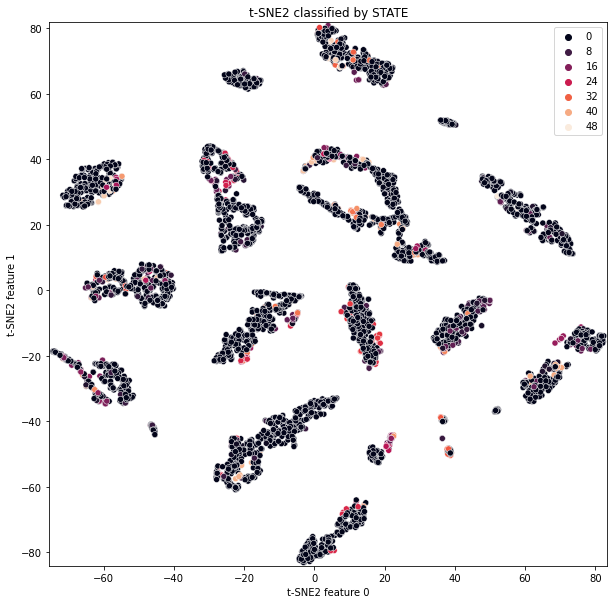

In [26]:
hue = states
plt.figure(figsize=(10,10))
plt.xlim(train_tsne2[:,0].min()-1,train_tsne2[:,0].max()+1)
plt.ylim(train_tsne2[:,1].min()-1,train_tsne2[:,1].max()+1)
sns.scatterplot(train_tsne2[:,0], train_tsne2[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE2 classified by STATE')
plt.xlabel('t-SNE2 feature 0')
plt.ylabel('t-SNE2 feature 1')
plt.show()

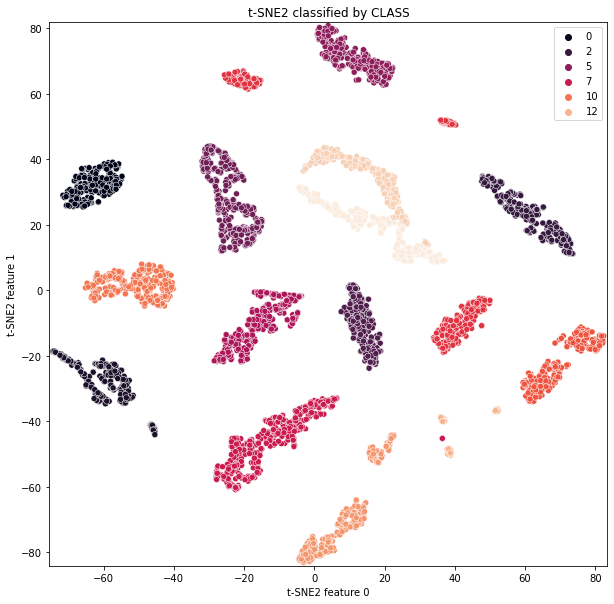

In [27]:
hue = classes
plt.figure(figsize=(10,10))
plt.xlim(train_tsne2[:,0].min()-1,train_tsne2[:,0].max()+1)
plt.ylim(train_tsne2[:,1].min()-1,train_tsne2[:,1].max()+1)
sns.scatterplot(train_tsne2[:,0], train_tsne2[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE2 classified by CLASS')
plt.xlabel('t-SNE2 feature 0')
plt.ylabel('t-SNE2 feature 1')
plt.show()

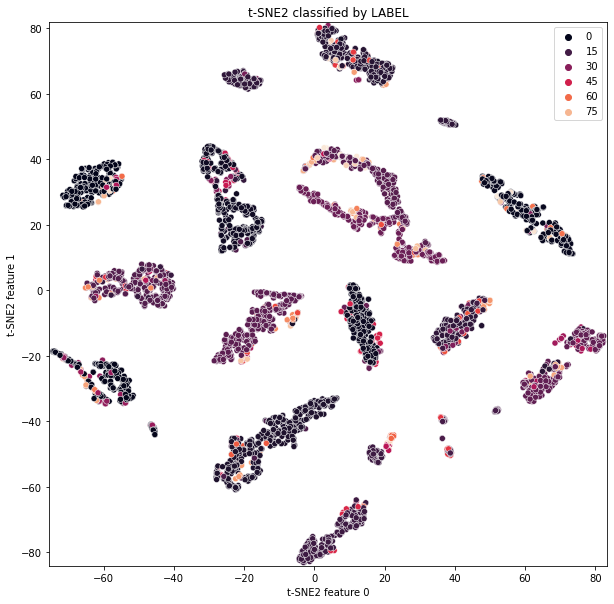

In [28]:
hue = labels
plt.figure(figsize=(10,10))
plt.xlim(train_tsne2[:,0].min()-1,train_tsne2[:,0].max()+1)
plt.ylim(train_tsne2[:,1].min()-1,train_tsne2[:,1].max()+1)
sns.scatterplot(train_tsne2[:,0], train_tsne2[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE2 classified by LABEL')
plt.xlabel('t-SNE2 feature 0')
plt.ylabel('t-SNE2 feature 1')
plt.show()

In [29]:
# 클러스터링 평가
classifier = KNeighborsClassifier(n_neighbors=1)
print(cross_val_score(classifier, train_tsne2, labels, cv=5).mean())

0.8190307154178281


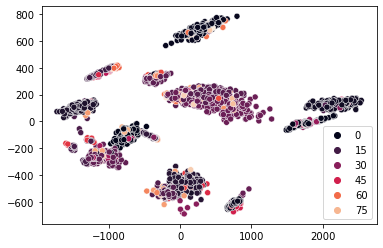

0.7498292069738208


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(results_array)

sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=labels,
                palette="rocket")
plt.show()

classifier = KNeighborsClassifier(n_neighbors=1)
print(cross_val_score(classifier, X_pca, labels, cv=5).mean())